# OLED Optimization with FourierFields


In [40]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

from meep.materials import Ag as Ag

mp.verbosity(0)

SiO2 = mp.Medium(epsilon=2.13)    # 글래스의 굴절률 설정
GaN = mp.Medium(epsilon=6.18)   # OLED 유기층의 굴절률 설정
Al2O3 = mp.Medium(epsilon=3.17)    # 실리콘 질화물의 굴절률 설정
Air = mp.Medium(epsilon=1.0)    # 공기의 굴절률 설정

Basic setup

In [41]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.8       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 1/(0.45) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 25             # 추출할 주파수 개수
design_region_resolution = 50                                                             

tSiO2 = 0.07    # passivation layer 두께
tAL = 0.1    # oxide side 두께
tAg = 0.07    # 은 층 두께
tGaN = 1   # GaN 층 두께
tPML = 0.1    # PML 두께
MtoPML = 0.05
MtoD = 0.05

L = 1.0       # OLED의 가로/세로 길이

design_region_width = L
design_region_height = 0.1

Sy = tPML + MtoPML + MtoD + design_region_height + tGaN + tAg   # Z 방향 전체 길이
Sx = L + 2*tSiO2 + + 2*tAL + 2*tPML                        # X/Y 방향 길이
cell_size = mp.Vector3(Sx, Sy)    # 시뮬레이션 셀 크기

boundary_layers = [mp.Absorber(0.1,direction=mp.X),
                   mp.PML(0.1,direction=mp.Y,side=mp.High)]

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), Air, SiO2, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(y=0.5*Sy - tPML - MtoPML - MtoD - 0.5*design_region_height),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    mp.Block(material=design_variables,      # 디자인 영역
             size=design_region.size,
             center=design_region.center),
    
    mp.Block(material=GaN,      # GaN 층
             size=mp.Vector3(L, tGaN),
             center=mp.Vector3(y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*tGaN)),
    
    mp.Block(material=Ag,                       # 은 층
             size=mp.Vector3(L, tAg),
             center=mp.Vector3(y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - tGaN - 0.5*tAg)),
    
    mp.Block(material=SiO2,                       # 글래스 층
             size=mp.Vector3(tSiO2, tGaN + tAg),
             center=mp.Vector3(x=0.5*Sx - tPML - tAL - 0.5*tSiO2, y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg) )),

    mp.Block(material=SiO2,                       # 글래스 층
             size=mp.Vector3(tSiO2, tGaN + tAg),
             center=mp.Vector3(x=-0.5*Sx + tPML + tAL + 0.5*tSiO2, y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg))),
    
    mp.Block(material=Al2O3,                       # 알루미늄 층
             size=mp.Vector3(tPML + tAL, tGaN + tAg),
             center=mp.Vector3(x=-0.5*Sx + 0.5*(tPML + tAL), y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg))),

    mp.Block(material=Al2O3,                       # 알루미늄 층
             size=mp.Vector3(tPML + tAL, tGaN + tAg),
             center=mp.Vector3(x=0.5*Sx - 0.5*(tPML + tAL), y=0.5*Sy - tPML - MtoPML - MtoD - design_region_height - 0.5*(tGaN + tAg))),
]

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = []
src_num = 7

for i in range(src_num):  # x 방향 루프
        sources.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - MtoPML - MtoD - design_region_height - tGaN + 0.5*tAg,
                    z = 0
                )
            )
        )

sim = []

for i in range(src_num):
    sim.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometry,
                      sources=[sources[i]],
                      extra_materials=[Ag],)
    )
                    

<Axes: xlabel='X', ylabel='Y'>

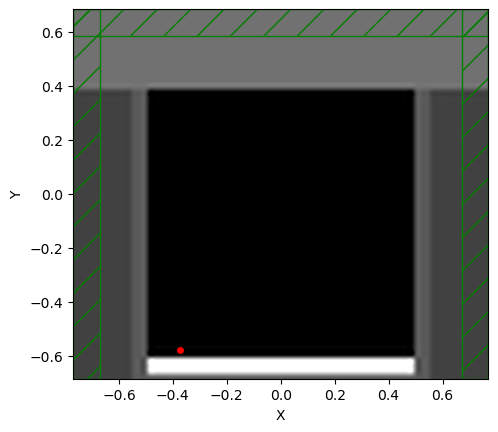

In [42]:
sim[0].plot2D()

In [43]:
r = 20/fcen
far_point = [mp.Vector3(0, r, 0)]
NearRegions = [
    mp.Near2FarRegion(
        center = mp.Vector3(0,0.5*Sy - tPML - MtoPML),
        size = mp.Vector3(L,0),
        weight = +1,
    )
]

FarFields = []
for i in range(src_num):
    FarFields.append(mpa.Near2FarFields(sim[i], NearRegions, far_point))

ob_list = []

for i in range(src_num):
    ob_list.append(FarFields[i])


def J(fields):
    return npa.real(npa.sum(fields[0, :, 2]*(npa.real(fields[0, :, 3])-npa.imag(fields[0, :, 3])*1j)))


opt = []
for i in range(src_num):
    opt.append(mpa.OptimizationProblem(
        simulation=sim[i],
        objective_functions=[J],
        objective_arguments=[ob_list[i]],
        design_regions=[design_region],
        frequencies=[fcen],
        maximum_run_time=100,
    ))

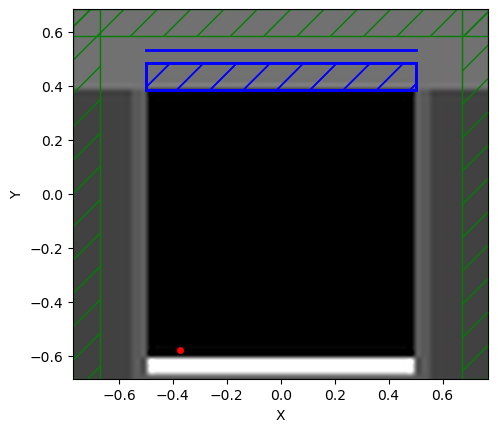

In [44]:
opt[0].plot2D(True)

In [45]:
minimum_length = 0.02  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

In [46]:
def mapping(x, eta, beta):

    # # filter
    # filtered_field = mpa.conic_filter(
    #     x,
    #     filter_radius,
    #     design_region_width,
    #     design_region_height,
    #     design_region_resolution,
    # )

    # # projection
    # projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return x

In [ ]:
evaluation_history = []
cur_iter = [0]
numevl = 1

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0 = []
    dJ_du = []

    global numevl

    for i in range(src_num):
        f0_i, dJ_du_i = opt[i]([mapping(v, eta_i, beta)])
        f0.append(f0_i.flatten())
        dJ_du.append(dJ_du_i)

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.sum(dJ_du, axis=0)
        )  # backprop

    evaluation_history.append([np.max(np.real(f0[i])) for i in range(src_num)])

    numevl += 1
    cur_iter[0] = cur_iter[0] + 1

    print("First FoM: {}".format(evaluation_history[0]))
    print("Current f0 values: " + ", ".join(["f0_{}: {}".format(i, np.real(f0[i])) for i in range(src_num)]))

    return np.mean(f0)  # return the sum of the objective function values


In [48]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 1.5
num_betas = 8
update_factor = 10
ftol = 1e-5
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

Current iteration: 1
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00602574], f0_1: [0.03438968], f0_2: [0.02535305], f0_3: [0.05087068], f0_4: [0.02535303], f0_5: [0.03438965], f0_6: [0.00602577]
Current iteration: 2
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00602603], f0_1: [0.03439533], f0_2: [0.02535652], f0_3: [0.05087314], f0_4: [0.02535651], f0_5: [0.0343953], f0_6: [0.00602606]
Current iteration: 3
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00602894], f0_1: [0.03445139], f0_2: [0.02539104], f0_3: [0.05089736], f0_4: [0.02539103], f0_5: [0.03445136], f0_6: [0.00602898]
Current iteration: 4
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00607717], f0_1: [0.03519141], f0_2: [0.0258486], f0_3: [0.05119384], f0_4: [0.02584859], f0_5: [0.03519137], f0_6: [0.0060772]
Current iteration: 5
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00700936], f0_1: [0.0412053], f0_2: [0.02979189], f0_3: [0.05197021], f0_4: [0.02979188], f0_5: [0.04120525], f0_6: [0.00700938]
Current iteration: 6
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00948183], f0_1: [0.05209178], f0_2: [0.04239767], f0_3: [0.04171173], f0_4: [0.04239771], f0_5: [0.05209174], f0_6: [0.00948182]
Current iteration: 7
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.0075776], f0_1: [0.0485984], f0_2: [0.04276206], f0_3: [0.06306708], f0_4: [0.04276205], f0_5: [0.04859838], f0_6: [0.00757763]
Current iteration: 8
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00966269], f0_1: [0.05143313], f0_2: [0.05129967], f0_3: [0.03670327], f0_4: [0.05129968], f0_5: [0.0514331], f0_6: [0.00966268]
Current iteration: 9
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00837768], f0_1: [0.05041939], f0_2: [0.04739496], f0_3: [0.05125081], f0_4: [0.04739495], f0_5: [0.05041937], f0_6: [0.0083777]
Current iteration: 10
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00857905], f0_1: [0.0516574], f0_2: [0.04907085], f0_3: [0.04560544], f0_4: [0.04907086], f0_5: [0.05165737], f0_6: [0.00857906]
Current iteration: 11
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00857905], f0_1: [0.0516574], f0_2: [0.04907085], f0_3: [0.04560544], f0_4: [0.04907086], f0_5: [0.05165737], f0_6: [0.00857906]
Current iteration: 12
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00857904], f0_1: [0.05165743], f0_2: [0.04907089], f0_3: [0.04560536], f0_4: [0.0490709], f0_5: [0.0516574], f0_6: [0.00857905]
Current iteration: 13
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00857904], f0_1: [0.05165743], f0_2: [0.04907089], f0_3: [0.04560536], f0_4: [0.0490709], f0_5: [0.0516574], f0_6: [0.00857905]
Current iteration: 14
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00857903], f0_1: [0.05165747], f0_2: [0.04907093], f0_3: [0.04560527], f0_4: [0.04907094], f0_5: [0.05165744], f0_6: [0.00857904]
Current iteration: 15
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00857903], f0_1: [0.05165747], f0_2: [0.04907093], f0_3: [0.04560527], f0_4: [0.04907094], f0_5: [0.05165744], f0_6: [0.00857904]
Current iteration: 16
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00857902], f0_1: [0.0516575], f0_2: [0.04907097], f0_3: [0.04560518], f0_4: [0.04907098], f0_5: [0.05165747], f0_6: [0.00857903]
Current iteration: 17
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00857902], f0_1: [0.0516575], f0_2: [0.04907097], f0_3: [0.04560518], f0_4: [0.04907098], f0_5: [0.05165747], f0_6: [0.00857903]
Current iteration: 18
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00857901], f0_1: [0.05165754], f0_2: [0.04907101], f0_3: [0.0456051], f0_4: [0.04907101], f0_5: [0.05165751], f0_6: [0.00857902]
Current iteration: 19
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00857901], f0_1: [0.05165754], f0_2: [0.04907101], f0_3: [0.0456051], f0_4: [0.04907101], f0_5: [0.05165751], f0_6: [0.00857902]
Current iteration: 20
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.008579], f0_1: [0.05165757], f0_2: [0.04907105], f0_3: [0.04560501], f0_4: [0.04907105], f0_5: [0.05165754], f0_6: [0.00857901]
Current iteration: 21
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.008579], f0_1: [0.05165757], f0_2: [0.04907105], f0_3: [0.04560501], f0_4: [0.04907105], f0_5: [0.05165754], f0_6: [0.00857901]
Current iteration: 22
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00857899], f0_1: [0.0516576], f0_2: [0.04907109], f0_3: [0.04560492], f0_4: [0.04907109], f0_5: [0.05165758], f0_6: [0.008579]
Current iteration: 23
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00857899], f0_1: [0.0516576], f0_2: [0.04907109], f0_3: [0.04560492], f0_4: [0.04907109], f0_5: [0.05165758], f0_6: [0.008579]
Current iteration: 24
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...


Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
First FoM: [0.006025739753014474, 0.03438968298827786, 0.025353046327654546, 0.050870681532526586, 0.02535303316625996, 0.034389645733754526, 0.006025771312248506]
Current f0 values: f0_0: [0.00857898], f0_1: [0.05165764], f0_2: [0.04907113], f0_3: [0.04560484], f0_4: [0.04907113], f0_5: [0.05165761], f0_6: [0.00857899]


In [49]:
np.savetxt("lastdesign.txt", design_variables.weights)

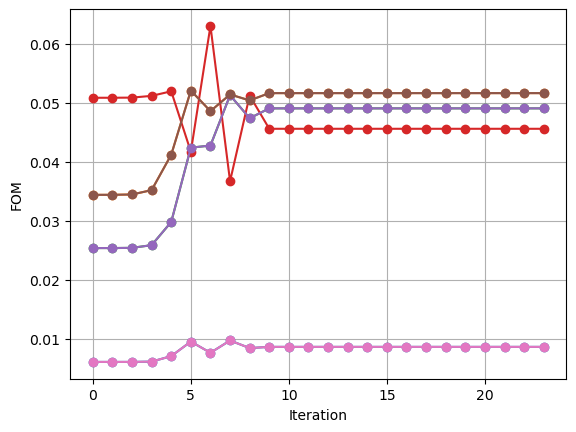

In [50]:
plt.figure()

plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

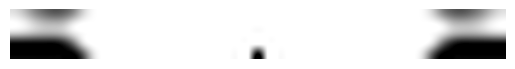

In [51]:
plt.figure()
ax = plt.gca()
opt[0].plot2D(
    False,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()

FloatProgress(value=0.0, description='0% done ', max=200.0)

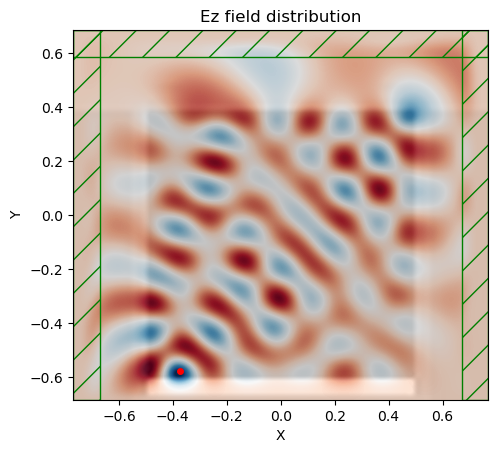

FloatProgress(value=0.0, description='0% done ', max=200.0)

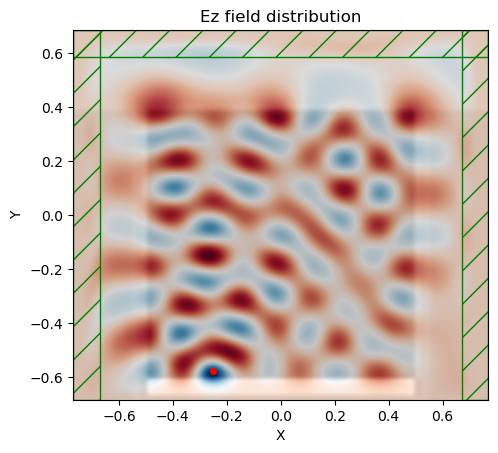

FloatProgress(value=0.0, description='0% done ', max=200.0)

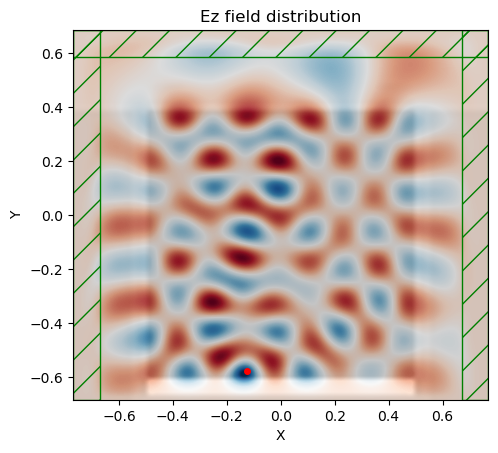

FloatProgress(value=0.0, description='0% done ', max=200.0)

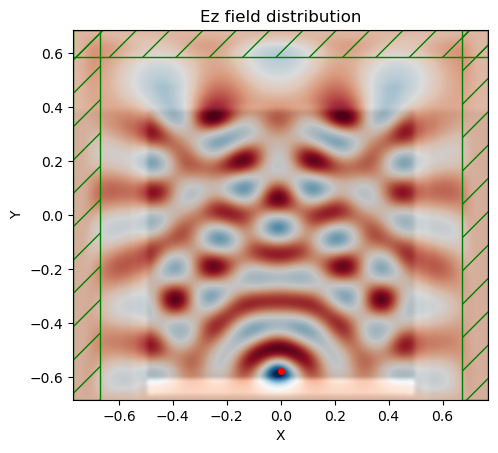

FloatProgress(value=0.0, description='0% done ', max=200.0)

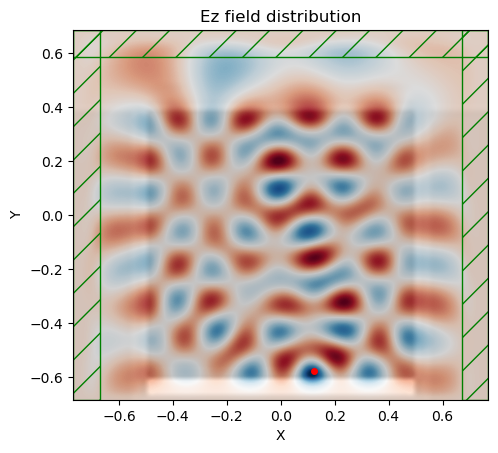

FloatProgress(value=0.0, description='0% done ', max=200.0)

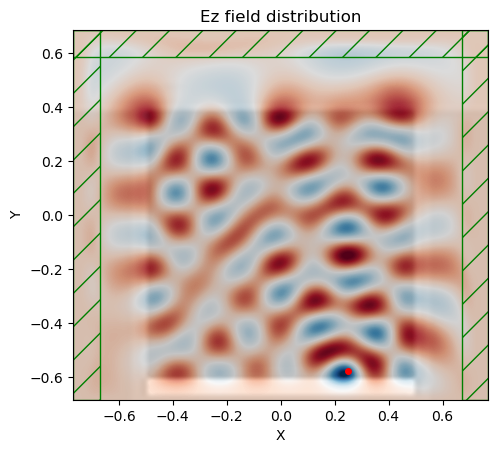

FloatProgress(value=0.0, description='0% done ', max=200.0)

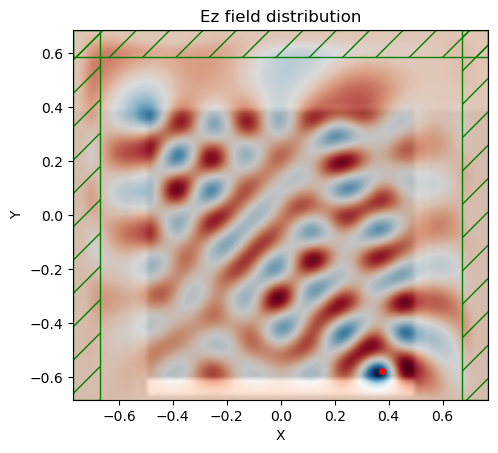

In [52]:
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = []

for i in range(src_num):  # x 방향 루프
        source.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - MtoPML - MtoD - design_region_height - tGaN + 0.5*tAg,
                    z = 0
                )
            )
        )
ppopt =[]
for i in range(src_num):
    ppopt.append(
        mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=boundary_layers,
                      geometry=geometry,
                      sources=[source[i]],
                      extra_materials=[Ag],)
    )

for i in range(src_num):
    ppopt[i].run(until=200)
    ppopt[i].plot2D(fields=mp.Ez) #, plot_sources_flag=False, plot_boundaries_flag=False, plot_monitors_flag=False)
    plt.title("Ez field distribution")
    plt.show()